Basic CNN Implemention With 2 convolutioanl Layers with 2 Fully connected layer

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.listdir('/content/drive/MyDrive/datasets/chest_xray')

['train', 'val', 'test']

Epoch [1/10], Train Loss: 0.2787, Val Loss: 0.3776, Val Accuracy: 87.50%, Time: 578.47s
Epoch [2/10], Train Loss: 0.1502, Val Loss: 0.7989, Val Accuracy: 56.25%, Time: 109.77s
Epoch [3/10], Train Loss: 0.1205, Val Loss: 0.4604, Val Accuracy: 81.25%, Time: 107.74s
Epoch [4/10], Train Loss: 0.1133, Val Loss: 0.4498, Val Accuracy: 68.75%, Time: 109.10s
Epoch [5/10], Train Loss: 0.1023, Val Loss: 0.2631, Val Accuracy: 87.50%, Time: 107.47s
Epoch [6/10], Train Loss: 0.0987, Val Loss: 1.0638, Val Accuracy: 56.25%, Time: 108.55s
Epoch [7/10], Train Loss: 0.0896, Val Loss: 0.2065, Val Accuracy: 93.75%, Time: 107.93s
Epoch [8/10], Train Loss: 0.0826, Val Loss: 0.4437, Val Accuracy: 75.00%, Time: 106.49s
Epoch [9/10], Train Loss: 0.0747, Val Loss: 0.3925, Val Accuracy: 81.25%, Time: 107.46s
Epoch [10/10], Train Loss: 0.0741, Val Loss: 0.8796, Val Accuracy: 62.50%, Time: 105.61s

✅ Training completed in 1548.61 seconds (~154.86 s/epoch)


<Figure size 600x600 with 0 Axes>

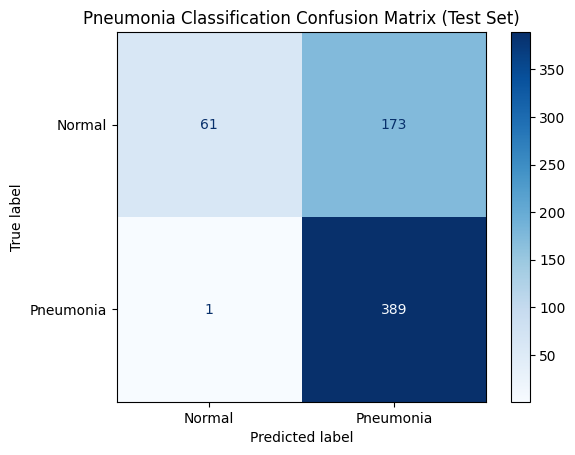

📊 Final Test Accuracy: 72.12%


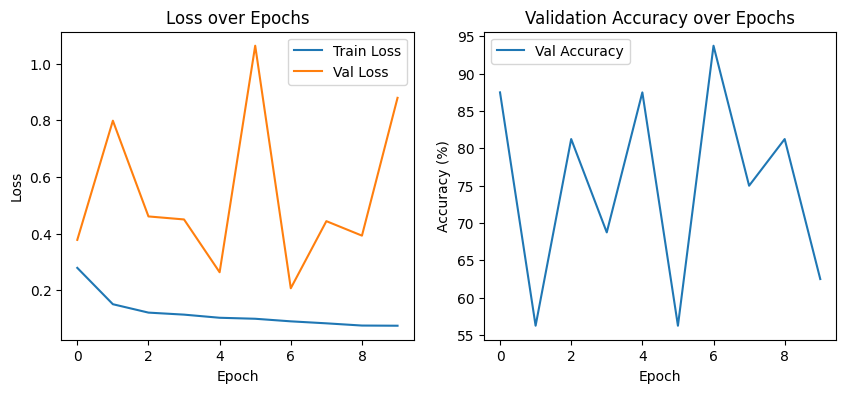

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# ---------------------------
# Hyperparameters
# ---------------------------
config = {
    "batch_size": 32,
    "learning_rate": 0.0001,
    "num_epochs": 10,
    "dropout": 0.5,
    "conv1_out_channels": 32,
    "conv2_out_channels": 64,
    "kernel_size": 3,
    "fc_hidden": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# ---------------------------
# Data Preprocessing
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Folders: train/, val/, test/
dataset_dir="/content/drive/MyDrive/datasets/chest_xray"
train_dataset = datasets.ImageFolder(root=f'{dataset_dir}/train', transform=transform)
val_dataset   = datasets.ImageFolder(root=f'{dataset_dir}/val', transform=transform)
test_dataset  = datasets.ImageFolder(root=f'{dataset_dir}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# ---------------------------
# CNN Model
# ---------------------------
class PneumoniaCNN(nn.Module):
    def __init__(self, config):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, config["conv1_out_channels"], kernel_size=config["kernel_size"], padding=1)
        self.conv2 = nn.Conv2d(config["conv1_out_channels"], config["conv2_out_channels"], kernel_size=config["kernel_size"], padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(config["dropout"])
        self.fc1 = nn.Linear(32*32*config["conv2_out_channels"], config["fc_hidden"])
        self.fc2 = nn.Linear(config["fc_hidden"], 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ---------------------------
# Training with Validation
# ---------------------------
model = PneumoniaCNN(config).to(config["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

train_losses, val_losses, val_accuracies = [], [], []

start_time = time.time()

for epoch in range(config["num_epochs"]):
    epoch_start = time.time()

    # ---- Training ----
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(config["device"]), labels.to(config["device"])
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total

    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1}/{config['num_epochs']}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy:.2f}%, "
          f"Time: {epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"\n✅ Training completed in {total_time:.2f} seconds "
      f"(~{total_time/config['num_epochs']:.2f} s/epoch)")

# ---------------------------
# Final Evaluation on Test Set
# ---------------------------
all_labels, all_preds = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(config["device"]), labels.to(config["device"])
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Pneumonia Classification Confusion Matrix (Test Set)")
plt.show()

test_accuracy = (cm.diagonal().sum() / cm.sum()) * 100
print(f"📊 Final Test Accuracy: {test_accuracy:.2f}%")

# ---------------------------
# Plot Loss & Accuracy
# ---------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.show()


📊 Final Test Accuracy: 72.12%


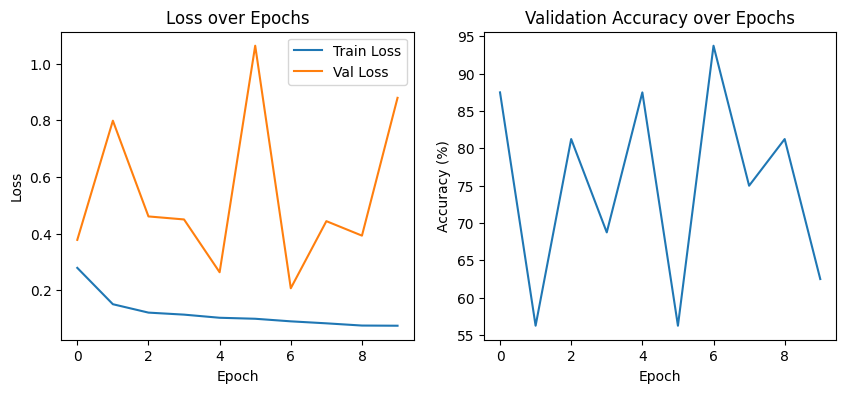

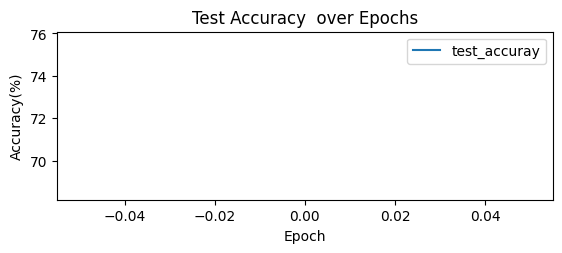

In [4]:
test_accuracy = (cm.diagonal().sum() / cm.sum()) * 100
print(f"📊 Final Test Accuracy: {test_accuracy:.2f}%")

# ---------------------------
# Plot Loss & Accuracy
# ---------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.subplot
plt.show()
plt.subplot(2,1,1)
plt.plot(test_accuracy, label="test_accuray")
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.title("Test Accuracy  over Epochs")
plt.legend()